In [1]:
import os
import argparse
import numpy as np
import torch
import sys
sys.path.append('common')
from BVH import load, save
from ForwardKinematics import *
from Quaternions import *

In [2]:
def get_coord(l, q, o):
    ret = o[l[0]]
    for i in l[1:]:
        ret = Quaternions(q[i]) * ret
        ret = ret + o[i]
    return ret


def fk(quats, offsets, parents):
    ret = np.zeros(offsets.shape)
    for i in range(len(ret)):
        curr_list = get_joints_list(parents, i)
        ret[i] = get_coord(curr_list, quats, offsets)
    return ret


In [3]:
def add_frame(anim, qs, order):
    ret = np.concatenate((anim.rotations.qs, qs), 0)
    anim.rotations.qs = ret
    anim.positions = np.concatenate((anim.positions, np.array([anim.positions[-1]])), 0)
    return anim

def get_joints_list(parents, joint_id):
    ret = [joint_id]
    curr = joint_id
    while parents[curr] != -1:
        ret.append(parents[curr])
        curr = parents[curr]
    return ret

def partial_deriv(fk, idx, eulers, order, target_idx, initial_pos, anim):
    ret = np.zeros((3,3))
    for i in range(3):
        eulers[idx][i] += 0.0001
        #print("eulers", eulers)
        rots = Quaternions.from_euler(eulers, order = order, world = False).qs
        #pos = fk.run_local(torch.Tensor(np.array([rots])).double())[0][0][target_idx]
        #print("rots", rots)
        pos = fk(rots, anim.offsets, anim.parents)[target_idx]
        #print("pos", pos)
        diff = pos - initial_pos
        ret[i] = diff/0.0001
        eulers[idx][i] -= 0.0001
    return ret

def analytical_deriv(pos, joint_num, initial_pos):
    ret = np.zeros((3,3))
    for i in range(3):
        axis = np.zeros(3)
        axis[2-i] = 1
        ret[i] = np.cross(axis, initial_pos - pos[joint_num]) 
    return ret

In [4]:
def build_jacobian(anim, joint_names, target_joint, target_pos, eulers, order, fk, mode = "numerical"):
    joint_id = joint_names.index(target_joint)
    joint_list = get_joints_list(anim.parents, joint_id)
    jacobian = np.zeros((len(joint_list)*3, 3))
    #initial_pos = fk.run_local(torch.Tensor(np.array([rots])).double())[0][0][joint_id]
    #print(Quaternions.from_euler(eulers, order = order).qs)
    pos = fk(Quaternions.from_euler(eulers, order = order).qs, anim.offsets, anim.parents)
    initial_pos = pos[joint_id]
    
    for i in range(len(joint_list)):
        if mode == "numerical":
            curr_pd = partial_deriv(fk, joint_list[i], eulers, order, joint_id, initial_pos, anim)
        else:
            curr_pd = analytical_deriv(pos, joint_list[i], initial_pos)
        jacobian[3*i]     = curr_pd[0]
        jacobian[3*i + 1] = curr_pd[1]
        jacobian[3*i + 2] = curr_pd[2]
    return jacobian.T, joint_list, initial_pos

def modify_eulers(eulers, diff, l, no_change = [], rate = 0.00001):
    for i in range(len(l)):
        if l[i] not in no_change:
            eulers[l[i]] += rate*diff[i]
    return eulers

In [17]:
def ik_t(anim, joint_names, target_joint, target_pos, order, fk, N = 300, no_change = [], rate = 0.0001, mode = "analytical"):
    curr_eulers = Quaternions(anim.rotations.qs[0]).euler(order = order)
    ret_eulers = []
    loss = [] 
    for i in range(N):
        print(i)
        for k in range(len(target_joint)):
            ret_eulers.append(np.copy(curr_eulers))
            j, l , ip = build_jacobian(anim, joint_names, target_joint[k], target_pos[k], curr_eulers, order, fk, mode = mode)
            de = target_pos[k] - np.array(ip)
            loss.append(np.linalg.norm(de))
            shifts = j.T@de.T
            shifts = np.array([shifts]).reshape((len(shifts)//3, 3))
            curr_eulers = modify_eulers(curr_eulers, shifts, l, no_change = no_change, rate = rate)
        anim = add_frame(anim, np.array([Quaternions.from_euler(curr_eulers, order = order[::-1]).qs]), order)
    ret_eulers.append(curr_eulers)
    return anim, np.array(ret_eulers), loss

def ik_pi(anim, joint_names, target_joint, target_pos, order, fk, N = 1000, lam = 10, no_change = [], rate = 0.01):
    curr_eulers = anim.rotations.euler(order = order)[0]
    ret_eulers = []
    loss = []
    for i in range(N):
        print(i)
        for k in range(len(target_joint)):
            ret_eulers.append(np.copy(curr_eulers))
            #print(curr_eulers[-4])
            j, l , ip = build_jacobian(anim, joint_names, target_joint[k], target_pos[k], curr_eulers, order, fk, mode = "analytical")
            #print(l)
            de = target_pos[k] - np.array(ip)
            pseudo_inv = j.T@(np.linalg.inv(j@j.T + lam*lam*np.diag([1.0,1.0,1.0])))
            #print(j@j.T)
            shifts = pseudo_inv@de.T
            #print(pseudo_inv)
            #print(shifts)
            print(np.linalg.norm(de))
            shifts = np.array([shifts]).reshape((len(shifts)//3, 3))
            curr_eulers = modify_eulers(curr_eulers, shifts, l, no_change = no_change, rate = rate)
        anim = add_frame(anim, np.array([Quaternions.from_euler(curr_eulers, order = order[::-1]).qs]), order)
    ret_eulers.append(curr_eulers)
    return anim, np.array(ret_eulers)

In [6]:
src_path = 'data/tentacle.bvh'
dst_path = 'output/'
os.makedirs(dst_path, exist_ok=True)
anim, joint_names, frame_time, order = load(src_path)

In [27]:
t_poses = [np.array([-15.0,10.0,10.0])]
t_joints = ["Spine4"]
iters = 150
uc = []#[1, 2, 3, 33]
rate = 0.0001
mode = "analytical"

out, ret_eulers, loss_analytical = ik_t(anim, joint_names, t_joints, t_poses, order, fk, N = iters, no_change = uc, rate = rate, mode = mode)

mode = "numerical"
out, ret_eulers, loss_numerical = ik_t(anim, joint_names, t_joints, t_poses, order, fk, N = iters, no_change = uc, rate = rate, mode = mode)

zyx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
zyx
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [11]:
save(os.path.join('output', 'tentacle_pi.bvh'), anim, np.degrees(ret_eulers), joint_names, frame_time, order)  

xyz


IndexError: index 1001 is out of bounds for axis 0 with size 1001

In [9]:
from matplotlib import pyplot as plt

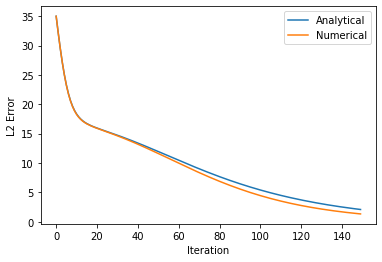

In [30]:
plt.plot(np.arange(150), loss_analytical, label = "Analytical")
plt.plot(np.arange(150), loss_numerical, label = "Numerical")
plt.xlabel("Iteration")
plt.ylabel("L2 Error")
plt.legend()
plt.show()